In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import bioframe 
import pandas as pd
import numpy as np 
import os
import json
from io import StringIO

import pysam
import h5py

from Bio import motifs
from Bio.Seq import Seq

In [2]:
import sys

sys.path.insert(0, "/home1/smaruj/akita_utils/")

from akita_utils import *

2022-07-05 15:59:22.072434: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-05 15:59:22.077964: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /spack/apps/linux-centos7-x86_64/gcc-8.3.0/pmix-3.1.3-3sm6emyqaxapunh7rwbjvtaqoqe2e5z3/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openmpi-4.0.2-ipm3dnvlbtxawpi4ifz7jma6jgr7mexq/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openblas-0.3.8-2no6mfziiclwxb7lstxoos335gnhjpes/lib:/spack/apps/gcc/8.3.0/lib64:/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib:/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib
2022-07-05 15:59:22.

In [3]:
genome_open = pysam.Fastafile("/project/fudenber_735/genomes/mm10/mm10.fa")
rmsk_file = "/project/fudenber_735/genomes/mm10/database/rmsk.txt.gz"

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
print("Tensorflow: ", tf.__version__)

from basenji import dataset, seqnn, dna_io, stream

Tensorflow:  2.9.1


In [5]:
rmsk_cols = pd.read_csv(
        StringIO(
            "bin	swScore	milliDiv	milliDel	milliIns	genoName	genoStart	genoEnd	genoLeft	strand	repName	repClass	repFamily	repStart	repEnd	repLeft	id"
        ),
        sep="\t")

rmsk = pd.read_table(
        rmsk_file,
        names=rmsk_cols.keys())

rmsk.rename(
        columns={"genoName": "chrom", "genoStart": "start", "genoEnd": "end"},
        inplace=True)

In [6]:
rmsk

,bin,swScore,milliDiv,milliDel,milliIns,chrom,start,end,genoLeft,strand,repName,repClass,repFamily,repStart,repEnd,repLeft,id
0,607,12955,105,9,10,chr1,3000000,3002128,-192469843,-,L1_Mus3,LINE,L1,-3055,3592,1466,1
1,607,1216,268,31,105,chr1,3003152,3003994,-192467977,-,L1Md_F,LINE,L1,-5902,617,1,2
2,607,234,279,0,0,chr1,3003993,3004054,-192467917,-,L1_Mus3,LINE,L1,-6034,297,237,3
3,607,3685,199,21,14,chr1,3004040,3004206,-192467765,+,L1_Rod,LINE,L1,1321,1492,-4355,4
4,607,376,62,31,0,chr1,3004206,3004270,-192467701,+,(CAAA)n,Simple_repeat,Simple_repeat,4,69,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5333734,586,8702,95,80,89,chrna_GL456050_alt,140098,140367,-1974,+,RMER16-int,LTR,ERVK,411,667,-4739,1
5333735,586,44,24,0,0,chrna_GL456050_alt,140367,140409,-1932,+,(AG)n,Simple_repeat,Simple_repeat,1,42,0,1
5333736,586,8702,95,80,89,chrna_GL456050_alt,140409,140631,-1710,+,RMER16-int,LTR,ERVK,668,930,-4476,1
5333737,586,5082,56,3,0,chrna_GL456050_alt,140631,141216,-1125,-,LTRIS_Mus,LTR,ERV1,0,587,1,1


In [7]:
SINEB2 = rmsk[rmsk["repClass"] == "SINE"][rmsk["repFamily"] == "B2"]
SINEB2.index = [i for i in range(len(SINEB2))]

/tmp/ipykernel_1166665/2162699272.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  SINEB2 = rmsk[rmsk["repClass"] == "SINE"][rmsk["repFamily"] == "B2"]


In [8]:
SINEB2

,bin,swScore,milliDiv,milliDel,milliIns,chrom,start,end,genoLeft,strand,repName,repClass,repFamily,repStart,repEnd,repLeft,id
0,607,797,201,147,0,chr1,3013180,3013364,-192458607,-,B3,SINE,B2,-2,214,4,1
1,608,938,151,7,13,chr1,3050778,3050932,-192421039,-,B2_Mm2,SINE,B2,-41,154,2,5
2,608,1272,57,0,0,chr1,3063370,3063529,-192408442,-,B2_Mm1t,SINE,B2,-33,160,2,6
3,608,497,321,71,56,chr1,3114021,3114219,-192357752,-,B3A,SINE,B2,-1,215,15,1
4,608,1019,252,5,0,chr1,3118142,3118352,-192353619,+,B3,SINE,B2,1,211,-5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390811,587,1095,131,0,6,chrY_JH792834_fix,276059,276228,-55252,+,B2_Mm2,SINE,B2,1,168,-27,4
390812,587,682,190,147,12,chrY_JH792834_fix,283063,283228,-48252,-,B2_Mm2,SINE,B2,-4,191,1,4
390813,587,559,303,25,34,chrY_JH792834_fix,326196,326401,-5079,+,B3,SINE,B2,13,215,-1,4
390814,585,740,136,156,36,chrna_GL456050_alt,6143,6311,-136030,+,B2_Mm2,SINE,B2,1,192,-3,1


In [ ]:
# https://doi.org/10.1016/j.cell.2019.08.007
# The mouse genome contains more than 370,000 annotated SINE B2 elements, of which 42% (~156,000) contain a CTCF binding motif (Figure S6B). 
# However, only 25% (~39,000) of these bind- ing sites are bound by CTCF or ADNP.

In [ ]:
# >MA0139.1	CTCF
# A  [    87    167    281     56      8    744     40    107    851      5    333     54     12     56    104    372     82    117    402 ]
# C  [   291    145     49    800    903     13    528    433     11      0      3     12      0      8    733     13    482    322    181 ]
# G  [    76    414    449     21      0     65    334     48     32    903    566    504    890    775      5    507    307     73    266 ]
# T  [   459    187    134     36      2     91     11    324     18      3      9    341      8     71     67     17     37    396     59 ]

In [9]:
fh = open("CTCF.txt")
for m in motifs.parse(fh, "jaspar"):
    motif = m

pssm = motif.pssm
motif.consensus

Seq('TGGCCACCAGGGGGCGCTA')

In [ ]:
# score_list = []
# position_list = []
# length_list = []
# for i in [j for j in range(len(SINEB2))]:
#     try:
#         SINEB2_sequence = Seq(genome_open.fetch(SINEB2["chrom"][i], SINEB2["start"][i], SINEB2["end"][i]).upper())
#         for position, score in pssm.search(SINEB2_sequence, threshold=15.0):
#             score_list.append(score)
#             position_list.append(position)
#             length_list.append(abs(SINEB2["end"][i] - SINEB2["start"][i]))
#             # print(i, "Position %d: score = %5.3f" % (position, score))
#     except:
#         continue

In [ ]:
# df = pd.DataFrame(list(zip(score_list, position_list, length_list)), columns =["score", "position", "length"])

In [ ]:
# print(len(score_list))
# plt.figure(figsize=(12,8))
# # sns.histplot(data=score_list)

# ax = sns.histplot(data=df, x="score")
# ax.set(xlabel='score', ylabel='count')
# # plt.savefig("SINEB2_scores_hist.png")
# plt.show()

In [ ]:
# plt.figure(figsize=(12,8))
# # sns.histplot(data=score_list)

# ax = sns.histplot(data=df, x="position")
# ax.set(xlabel='position', ylabel='count')
# # plt.savefig("SINEB2_scores_hist.png")
# plt.show()

In [ ]:
# NOT RIGHT

# def directional_position(row):
#     if row["position"] > 0:
#         return row["position"]
#     else:
#         return row["length"] + row["position"]

# df["dir_position"] = df.apply(directional_position, axis=1)

In [ ]:
# df["abs_position"] = df["position"].apply(lambda x: abs(x))
# df["strand"] = df["position"].apply(lambda x: np.sign(x))
# df

In [ ]:
# plt.figure(figsize=(12,8))
# # sns.histplot(data=score_list)

# ax = sns.histplot(data=df, x="abs_position", hue="strand")
# ax.set(xlabel='position', ylabel='count')
# # plt.savefig("SINEB2_scores_hist.png")
# plt.show()

In [10]:
i = 3220
Position = 51
Scoretest = Seq(genome_open.fetch(SINEB2["chrom"][i], SINEB2["start"][i], SINEB2["end"][i]).upper())

print("Concensus: TGGCCACCAGGGGGCGCTA")
if Position > 0:
    print("Found: ", Scoretest[Position:Position+19])
else:
    print("Found: ", Scoretest[Position:Position-19].reverse_complement())

Concensus: TGGCCACCAGGGGGCGCTA
Found:  TGGCCAGAAGAGGGCACCA


In [11]:
SINEB2.iloc[3220]

bin                 861
swScore             824
milliDiv            183
milliDel             51
milliIns             17
chrom              chr1
start          36256381
end            36256559
genoLeft     -159215412
strand                -
repName          B2_Mm2
repClass           SINE
repFamily            B2
repStart            -10
repEnd              185
repLeft               2
id                    5
Name: 3220, dtype: object

In [12]:
flank = 20
trimmed_SINEB2_CTCF = Seq(genome_open.fetch(SINEB2["chrom"][i], SINEB2["start"][i] + Position - flank, SINEB2["start"][i] + Position + 19 + flank).upper())
insert_length = len(trimmed_SINEB2_CTCF)

In [ ]:
# flank = 50
# trimmed_SINEB2_CTCF = Seq(genome_open.fetch(SINEB2["chrom"][i], SINEB2["start"][i], SINEB2["end"][i]).upper())
# insert_length = len(trimmed_SINEB2_CTCF)

In [13]:
insert_length

59

In [14]:
# NOTE
# head_i = 0 #human
# head_i = 1 #mouse
#

head_i = 1 #mouse
# head_i = 0
model_num = 1 #which fold to use


#base_dir = '/project/fudenber_735/backup/DNN_HiC/human-mouse_5-16-21/'
#model_dir = base_dir+"/f"+str(model_num)+"_c0/train/"

base_dir = "/project/fudenber_735/tensorflow_models/akita/v2/models/"
model_dir = base_dir + "/f" + str(model_num) + "c0/train/"
model_file  = model_dir + "/model" + str(head_i) + "_best.h5"


# model_dir = '/home1/fudenber/repositories/basenji/manuscripts/akita/'
# model_file = model_dir+'/model_best.h5'

params_file = model_dir + "/params.json"
# params_file -> json (dict) with model's parameters
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params["model"]
    params_train = params["train"]
seq_length = params_model["seq_length"]
params_model["verbose"] = False

seqnn_model = seqnn.SeqNN(params_model)
print("built")

seqnn_model.restore(model_file, head_i=head_i)    # model with the mouse head
print("restored")


2022-07-05 16:00:59.139344: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /spack/apps/linux-centos7-x86_64/gcc-8.3.0/pmix-3.1.3-3sm6emyqaxapunh7rwbjvtaqoqe2e5z3/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openmpi-4.0.2-ipm3dnvlbtxawpi4ifz7jma6jgr7mexq/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openblas-0.3.8-2no6mfziiclwxb7lstxoos335gnhjpes/lib:/spack/apps/gcc/8.3.0/lib64:/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib:/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib
2022-07-05 16:00:59.139402: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-05 16:00:59.139438: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (endeavour1.usc.edu): /proc/driver/nvidia/version does 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 1310720, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 stochastic_reverse_complement   ((None, 1310720, 4)  0          ['sequence[0][0]']               
 (StochasticReverseComplement)  , ())                                                             
                                                                                                  
 stochastic_shift (StochasticSh  (None, 1310720, 4)  0           ['stochastic_reverse_complement[0
 ift)                                                            ][0]']                     

In [15]:
hic_diags = params_model["diagonal_offset"]
try:
    target_crop = params_model["trunk"][-2]["cropping"]
except:
    target_crop = params_model["target_crop"]

print("hic_diags: ", hic_diags) 
print("target_crop: ", target_crop)
print("seq_length: ", seq_length)

target_length_cropped = int((seq_length//2048 - target_crop*2 - hic_diags) * ((seq_length//2048 - target_crop*2 - hic_diags) +1)/2) 
target_map_size = seq_length//2048  - target_crop*2 
triu_tup = np.triu_indices(target_map_size, 2)    # Return the indices for the upper-triangle of an (n, m) array, here k=2 (diagonal offset)
# target_map_size, target_length_cropped, triu_tup[0].shape

print("target_length_cropped: ", target_length_cropped)
print("target_map_size: ", target_map_size)
print("shape of triu_tup[0]: ", triu_tup[0].shape)

hic_diags:  2
target_crop:  64
seq_length:  1310720
target_length_cropped:  130305
target_map_size:  512
shape of triu_tup[0]:  (130305,)


In [16]:
background_file = base_dir + '../analysis/background_seqs.fa'
background_seqs = []
with open(background_file,'r') as f:
  for line in f.readlines():
    if '>' in line: continue
    background_seqs.append(dna_io.dna_1hot(line.strip())) 

In [17]:
spacer_bp = 0
num_inserts = 6
multi_insert_length = num_inserts * (insert_length+spacer_bp)

offsets = []
for i in range(num_inserts):
    offsets.append( seq_length//2 - multi_insert_length//2 + i * (insert_length+spacer_bp))
offsets, seq_length//2

([655183, 655242, 655301, 655360, 655419, 655478], 655360)

In [23]:
all_inserts = []
i = 3220
for background_seq in background_seqs[0:1]:
  seq_1hot = background_seq.copy()
  seq_1hot_motif = dna_io.dna_1hot(genome_open.fetch(SINEB2["chrom"][i], SINEB2["start"][i] + Position - flank, SINEB2["start"][i] + Position + 19 + flank).upper())
  print(Seq(genome_open.fetch(SINEB2["chrom"][i], SINEB2["start"][i] + Position - flank, SINEB2["start"][i] + Position + 19 + flank).upper()))
  # seq_1hot_motif = dna_io.dna_1hot(genome_open.fetch(SINEB2["chrom"][i], SINEB2["start"][i], SINEB2["end"][i]).upper())
  if SINEB2["strand"][i] == '-': seq_1hot_motif = dna_io.hot1_rc(seq_1hot_motif)
  for offset in offsets:
    # print(offset)
    # print(insert_length)
    seq_1hot[offset:offset+insert_length] = seq_1hot_motif
  all_inserts.append(seq_1hot)
all_inserts = np.array(all_inserts)

TCTGCCTGAATGTATGCTTGTGGCCAGAAGAGGGCACCAGATTACACTACAGATGGTTG


In [19]:
all_inserts.shape

(1, 1310720, 4)

In [ ]:
# for i in range(len(chrom)):
#     if i == 0:
#         mouse_frag = dna_io.dna_1hot(genome_open.fetch(chrom[i], start[i], start[i] + chunk).upper())
#     else:
#         new_frag =  dna_io.dna_1hot(genome_open.fetch(chrom[i], start[i], start[i] + chunk).upper())
#         mouse_frag = np.stack((mouse_frag, new_frag), axis=0)

In [ ]:
# mouse_frag, mouse_frag.shape

In [20]:
pred = seqnn_model.predict(all_inserts)
                           # , batch_size=10)   # so 20/10 = 2 batches

1/1 [==============================] - 9s 9s/step


In [ ]:
# with_retro = dna_io.dna_1hot(genome_open.fetch(SINEB2["chrom"][i], SINEB2["start"][i] - half, SINEB2["end"][i] + half - 212).upper())
# len(with_retro)

In [ ]:
# without_retro = dna_io.dna_1hot(genome_open.fetch(SINEB2["chrom"][i], SINEB2["start"][i] - half, SINEB2["start"][i]).upper()
# + genome_open.fetch(SINEB2["chrom"][i], SINEB2["end"][i], SINEB2["end"][i] + half).upper())
# len(without_retro)

In [ ]:
# mouse_frag = np.stack((with_retro, without_retro), axis=0)
# mouse_frag.shape

In [ ]:
# pred = seqnn_model.predict(mouse_frag)

In [21]:
pred.shape

(1, 130305, 6)

In [ ]:
targets = ["mESC", "mESC", "cortical neuron", "neocortex cortical neuron", "neural progenitor cell", "neocortex neural progenitor cell"]
# targets = ["HFF", "H1hESC", "GM12878", "IMR90", "HCT116"]

In [ ]:

# plt.figure(figsize=(8,8))

# for j in range(pred.shape[-1]):
#     # plt.figure(figsize=(pred.shape[0]*5,pred.shape[-1]*5))
#     plt.figure(figsize=(8,8))
#     target_ind = j
#     vlim = .5
#     bin_mid = target_map_size//2
#     window = 50

#     for i in range(len(pred)):
#         insert_pred = pred[:,:,i]
#         # print(i, np.sqrt( (insert_pred**2).sum(axis=0)))

#         plt.subplot(pred.shape[0], 2, i+1)
#         plt.axis("off")
#         im = plt.matshow(
#                 from_upper_triu(  
#                 insert_pred, target_map_size, hic_diags),
#                 vmin=-1*vlim, vmax=vlim, fignum=False, cmap="RdBu_r")
#         plt.colorbar(im, fraction=0.046, pad=0.04)
#         plt.title("scd: " + str(  np.sqrt( (insert_pred**2).sum(axis=0)  ).mean()) + "\n"
#                  f"target: {targets[j]}")
#             #plt.axis([ bin_mid  - window,bin_mid+window,bin_mid-window, bin_mid+window])
#     plt.tight_layout()
#     plt.show()

In [ ]:
# plt.figure(figsize=(3*5,2*5))

# target_ind = 0
# vlim = .5
# bin_mid = target_map_size//2
# window = 50

# for i in range(pred.shape[-1]):
#     insert_pred = pred[0,:,i]
#     print(i, np.sqrt( (insert_pred**2).sum(axis=0)))

#     plt.subplot(2,3, i+1)
#     im = plt.matshow(
#             from_upper_triu(  
#             insert_pred, target_map_size,hic_diags),
#             vmin=-1*vlim, vmax=vlim, fignum=False,cmap='RdBu_r')
#     plt.colorbar(im, fraction=0.046, pad=0.04)
#     # plt.title('genomic-scd: '+str(seq_coords_df['genomic_SCD'].values[i]) +'\n'+
#     #           'insert-scd: '+str(  np.sqrt( (insert_pred**2).sum(axis=0)  ).mean() ) 
#     #           ) 
#     plt.title('insert-scd: '+str(  np.sqrt( (insert_pred**2).sum(axis=0)  ).mean() ) + "\n" + f"target: {targets[i]}"
#     )
#     #plt.axis([ bin_mid  - window,bin_mid+window,bin_mid-window, bin_mid+window])
# plt.tight_layout()
# plt.show()

0 [22.62 23.12 32.   22.84 23.53 22.62]


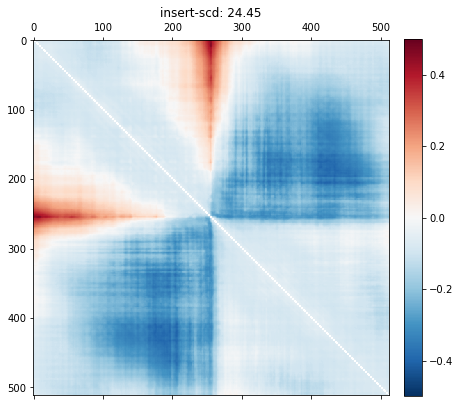

In [22]:
plt.figure(figsize=(30,30))

target_ind = 0
vlim = .5
bin_mid = target_map_size//2
window = 50
for i in range(1):
    insert_pred = pred[i]
    print(i, np.sqrt( (insert_pred**2).sum(axis=0)))

    plt.subplot(2,5, i+1)
    im = plt.matshow(
            from_upper_triu(  
            insert_pred[:,target_ind], target_map_size,hic_diags),
            vmin=-1*vlim, vmax=vlim, fignum=False,cmap='RdBu_r')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('insert-scd: '+str(  np.sqrt( (insert_pred**2).sum(axis=0)  ).mean() ) 
              ) 
    #plt.axis([ bin_mid  - window,bin_mid+window,bin_mid-window, bin_mid+window])
plt.tight_layout()
plt.show()

In [ ]:

# for j in range(pred.shape[-1]):
#     plt.figure(figsize=(pred.shape[0]*6,pred.shape[-1]*5))
#     target_ind = j
#     vlim = .5
#     bin_mid = target_map_size//2
#     window = 50

#     for i in range(len(pred)):
#         insert_pred = pred[i]
#         # print(i, np.sqrt( (insert_pred**2).sum(axis=0)))

#         plt.subplot(6, 2, i+1)
#         plt.axis("off")
#         im = plt.matshow(
#                 from_upper_triu(  
#                 insert_pred[:,target_ind], target_map_size, hic_diags),
#                 vmin=-1*vlim, vmax=vlim, fignum=False, cmap="RdBu_r")
#         plt.colorbar(im, fraction=0.046, pad=0.04)
#         plt.title("scd: " + str(  np.sqrt( (insert_pred[:,:,j]**2).sum(axis=0)  ).mean()) + "\n"
#                  f"target: {targets[j]}")
#             #plt.axis([ bin_mid  - window,bin_mid+window,bin_mid-window, bin_mid+window])
#     plt.tight_layout()
#     plt.show()

In [ ]:
# flanks = ["1x", "4x", "6x", "0-CTCF", "10", "20", "30", "40", "50"]
# scores = [10.76, 15.23, 19.23, 15.22, 20.61, 21.97, 19.39, 20.42, 19.]

# df = pd.DataFrame(list(zip(flanks, scores)), columns =['flanks', 'scores'])

In [ ]:
# plt.figure(figsize=(12,8))
# # sns.histplot(data=score_list)

# ax = sns.barplot(data=df, x="flanks", y="scores")
# ax.set(xlabel='variant', ylabel='score')
# # plt.savefig("SINEB2_scores_hist.png")
# plt.show()